# Projects notebook

```
Ezequiel Cimadevilla Álvarez
ezequiel.cimadevilla@unican.es

Santander Meteorology Group
Instituto de Física de Cantabria
Edificio Juan Jordá, Avenida de los Castros, s/n, E-39005 Santander, Cantabria, Spain

http://www.meteo.unican.es

Máster Data Science/Ciencia de Datos - 2024/2025
```

## Chunking performance study (4 points)

For this exercise you will create multiple datasets inside of a HDF5 file. Datasets will be created using multiple configurations and chunking schemes. You will measure creation time for the datasets, size of the datasets, and reading time from the datasets. Finally, you will display plots comparing different measurements and you will provide explanations that justify the measurements.

### HDF5 file structure

The datasets will have the following properties:

```python
n = 100_000
l = 2000

configs = [
    {"name": "s", "dtype": "i4", "shape": (n,l)},
    {"name": "d", "dtype": "i8", "shape": (n,l)},
    {"name": "gzip", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": True},
    {"name": "lzip", "dtype": "i8", "shape": (n,l), "compression": "lzf", "chunks": True},
    {"name": "row", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (1,l)},
    {"name": "col", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (l,1)},
    {"name": "shuf", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (1,l), "shuffle": True},
    {"name": "flet", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (1,l), "shuffle": True, "fletcher32": True},
]
```

Use the following function to generate the data to be stored

```python
(2 * np.random.randint(0, 1 + 1, (n, l)) - 1).cumsum(axis=1)
```

### Time and size measures

You will measure three parameters:

- Writing time.
- Reading time. You will test the following pattern: `[::20,:].mean(axis=1)`.
- Dataset size.

Writing time and dataset size will be measured while filling the dataset with the numerical data. Reading time will be measured afterwards.

For measuring reading and writing times, you can use the `time` module to store the current time before and after reading and writing as follows:

```python
import time

start = time.time()
dataset[:] = ...
h5file.flush() # force buffers to write to disk
end = time.time()

ellapsed_time = end - start # in milliseconds
```

For measuring file size, you can use the `os` module to record the HDF5 file size before and after filling the dataset:

```python
import os

size1 = os.stat(h5file.filename).st_size
dataset[:] = ...
h5file.flush() # force buffers to write to disk
size2 = os.stat(h5file.filename).st_size

dataset_size = size2 - size1 # in bytes
```

### Using plots to compare measurements

Create a table with the following structure in order to record measurements:

|    | name    |     metric |      value |
|---:|:--------|-----------:|-----------:|
|  0 | n1      | size       | 0.00294065 |
|  1 | n1      | rtime      | 0.0170555  |
|  2 | n1      | wtime      | 0.0291584  |
|  3 | n2      | size       | 0.0180824  |
|  4 | n2      | rtime      | 0.03249    |
|  5 | n2      | wtime      | 0.0328758  |
|  6 | n3      | size       | 0.0224636  |
|  7 | n3      | rtime      | 0.0469017  |
| ...| ...     | ...        | ...        |

Load the results into a Pandas DataFrame and plot three bar plots for each variable. Answer the following questions:

1. - Explain the differences in file sizes between the datasets with chunks and without chunks.
2. - Explain the differences in writing time depending on the configuration of the dataset.
3. - Do you appreciate any difference in reading times for the given pattern? Which is the cause of these differences?
4. - In your opinion, do you think that compression justifies more CPU time in exchange of less file size?

In [61]:
import h5py
import numpy as np
import os, time
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
n = 100_000
l = 200 #uso de 200 por memoria

results = []

configs = [
    {"name": "s", "dtype": "i4", "shape": (n,l)},
    {"name": "d", "dtype": "i8", "shape": (n,l)},
    {"name": "gzip", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": True},
    {"name": "lzip", "dtype": "i8", "shape": (n,l), "compression": "lzf", "chunks": True},
    {"name": "row", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (1,l)},
    {"name": "col", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (l,1)},
    {"name": "shuf", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (1,l), "shuffle": True},
    {"name": "flet", "dtype": "i8", "shape": (n,l), "compression": "gzip", "chunks": (1,l), "shuffle": True, "fletcher32": True},
]

In [81]:
with h5py.File("datasets_project_1.h5", "w") as file:
    
    for c in configs:
        name = c.pop("name")  # Extraer el nombre (Se usa pop() para evitar que la clave "name" se pase como parámetro cuando se crea el dataset.)
        shape = c["shape"]  # Extraer la forma para los datos
        dtype = c["dtype"]  # Extraer el tipo de datos
        
        # Crear el dataset
        dataset = file.create_dataset(name, **c)
        
        #Medición de tiempo de escritura y tamaño inicial
        size_s = os.stat(file.filename).st_size 
        start_w = time.time() 

        # Generar los datos
        data = (2 * np.random.randint(0, 1 + 1, shape, dtype=dtype) - 1).cumsum(axis=1)
        
        #cargar datos
        dataset[...] = data  # Cargar datos en el dataset
        file.flush()
        
        #Medición de tiempo de escritura y tamaño final
        size_e = os.stat(file.filename).st_size
        end_w = time.time()
        
        # Calculos de tiempo y tamaño para cada archivo configurado
        ds_size = size_e - size_s # in bytes
        write_time = end_w - start_w # in seconds

        results.append({'name' : name, 'wtime' : write_time, "size" : ds_size}) 

In [82]:
with h5py.File("datasets_project_1.h5", "r") as file:
    for result in results:
        name = result["name"]
        dataset = file[name]  # Obtener el el nombre del dataset

        # Medir el tiempo de lectura inicial
        start_r = time.time()
        
        # Acceder a los datos (lectura)
        read_data = dataset[::20, :].mean(axis=1)

        # Medir el tiempo de lectura inicial
        end_r = time.time()

        # Calcular el tiempo de lectura
        result['rtime'] = end_r - start_r 


In [83]:
#inspeccion de tiempos
print(results)

[{'name': 's', 'wtime': 0.33475756645202637, 'size': 80001952, 'rtime': 0.04512166976928711}, {'name': 'd', 'wtime': 0.5873048305511475, 'size': 160000000, 'rtime': 0.08990740776062012}, {'name': 'gzip', 'wtime': 2.011993408203125, 'size': 15165435, 'rtime': 0.5354855060577393}, {'name': 'lzip', 'wtime': 0.7171318531036377, 'size': 35439702, 'rtime': 0.39455723762512207}, {'name': 'row', 'wtime': 4.429584980010986, 'size': 21538971, 'rtime': 0.19555282592773438}, {'name': 'col', 'wtime': 4.589611768722534, 'size': 33508654, 'rtime': 4.566283464431763}, {'name': 'shuf', 'wtime': 3.7671711444854736, 'size': 18659499, 'rtime': 0.15256667137145996}, {'name': 'flet', 'wtime': 3.6908411979675293, 'size': 19072753, 'rtime': 0.14811325073242188}]


In [84]:
#Inspección de información
with h5py.File("datasets_project_1.h5", "r") as file:
    # Acceder al dataset 's'
    s = file["s"]
    # Consultar la forma del dataset
    print("Forma de ds s:", s.shape)
    # Ver el primer caminante y sus primeros 10 pasos
    print("Primer caminante (primeros 10 pasos):")
    print(s[0, :10]) 

    # Acceder al dataset 'row'
    row = file["row"]
    # Consultar la forma del dataset
    print("Forma de ds row:", row.shape)
    # Ver el primer caminante y sus primeros 10 pasos
    print("Primer caminante (primeros 10 pasos):")
    print(row[0, :10]) 
    

Forma de ds s: (100000, 200)
Primer caminante (primeros 10 pasos):
[1 0 1 2 3 4 3 2 1 2]
Forma de ds row: (100000, 200)
Primer caminante (primeros 10 pasos):
[-1  0 -1  0 -1  0  1  0 -1 -2]


In [85]:
df = pd.DataFrame(results)
print(df)

   name     wtime       size     rtime
0     s  0.334758   80001952  0.045122
1     d  0.587305  160000000  0.089907
2  gzip  2.011993   15165435  0.535486
3  lzip  0.717132   35439702  0.394557
4   row  4.429585   21538971  0.195553
5   col  4.589612   33508654  4.566283
6  shuf  3.767171   18659499  0.152567
7  flet  3.690841   19072753  0.148113


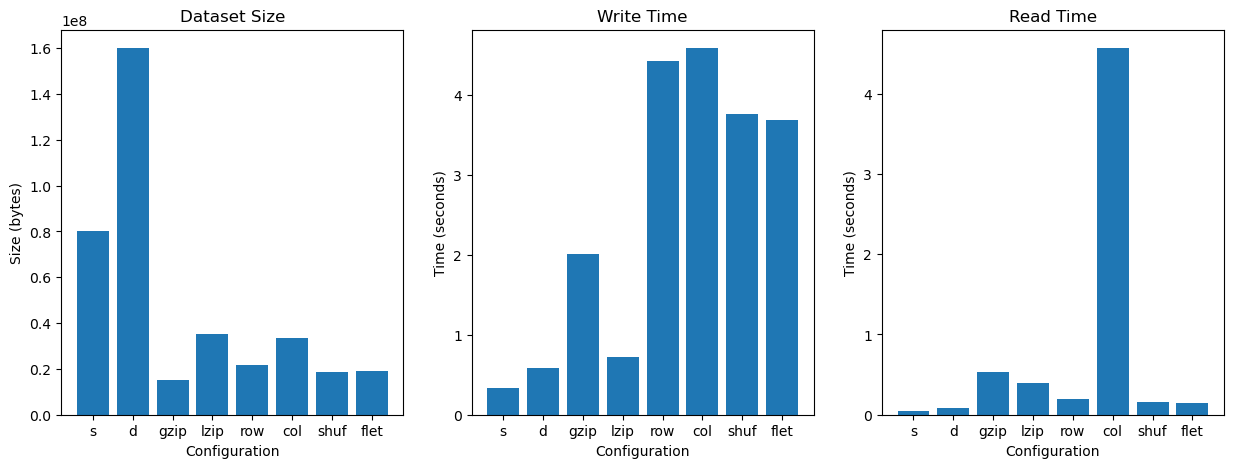

In [86]:
# Grafico compuesto de 3 graficos de barras
plt.figure(figsize=(15, 5))

# Grafico de tamaño del dataset
plt.subplot(1, 3, 1)
plt.bar(df['name'], df['size'])
plt.title('Dataset Size')
plt.xlabel('Configuration')
plt.ylabel('Size (bytes)')

# Grafico del tiempo de escritura
plt.subplot(1, 3, 2)
plt.bar(df['name'], df['wtime'])
plt.title('Write Time')
plt.xlabel('Configuration')
plt.ylabel('Time (seconds)')

# Grafico del tiempo de lectura
plt.subplot(1, 3, 3)
plt.bar(df['name'], df['rtime'])
plt.title('Read Time')
plt.xlabel('Configuration')
plt.ylabel('Time (seconds)')

plt.show()

1. Explain the differences in file sizes between the datasets with chunks and without chunks.

En la primera gráfica se observa que existe una diferencia amplia en el tamaño de los archivos que usan chunks y los que no, donde los dos que no usan (s y d) tienen un tamaño mucho mas grande que los que si lo usan, especialmente el de type i8 que representa el doble del tamaño del dataset type i4 y aproximadamente 4 veces más el tamaño de los que usan chunks. Este comportamiento se debe a que la configuración de chunks reduce la redundancia en los datos. 

Por su parte, es importante destacar en esta gráfica al comparar los dos métodos de chunks (gzip y lzip), el primero es mucho mas pequeño. Esto se debe a que la principal caracteristica de gzip es que reduce el tamaño pero es mucho mas lento, a diferencia de lzip que tiene una menor compresión pero es más rápido.  

2. Explain the differences in writing time depending on the configuration of the dataset.

En la gráfica dos se observa el comportamiento de escritura segun la configuración del dataset, donde s y d son más rápidos que los dataset que manejan chunks, a excepción de la configuración que usa lzip, que muestra un tiempo de escritura muy cercano al archivo d (con un tamaño igual y el mismo type de datos, i8). Esto último se debe a que este método se caracteriza por tener una velocidad más rápida que gzip a costa de menor compresión. Es importante destacar que los dataset s y d son más rápidos debido a que los datos se escriben directamente en disco sin un procesamiento adicional.

Por otro lado, se observa la diferencia entre gzip predeterminado y cuando se configura hacer los chunks por fila o columna, debido a que en el predeterminado va a depender del tamaño del dataset, y el tiempo de escritura depende del tamaño de los chunks, donde chunks mas pequeños seran más lentos porque se procesan muchas más particiones. Por esta razon, se observa que al hacer chunks por filas o por columnas es mucho más lento la escritura que si implementa el predeterminado (filas y columnas es una mayor cantidad de chunks). Ahora bien, se observa que hay una diferencia entre row y col, donde el primero es un poco más rápido debido a que los datos se escriben secuencial en memoria, a diferencia de las columnas que requiere una organización fragmentada (saltos de bloques).

Finalmente, se observa una reducción en el proceso de escritura con chunks en filas cuando se usan los filtros shuffle y fletcher32, lo cual se debe a que el primero disminuye tiempo de escritura al reorganizar bytes y el segundo mejora aspectos de integridad de los datos, pero con tiempos de procesamiento más altos que la configuración estandar de gzip. La diferencia de usar fletcher32 en el filtro no es tan significativa, la reducción radica mas en el filtro de shuffle. 

3. Do you appreciate any difference in reading times for the given pattern? Which is the cause of these differences?

En la gráfica 3 se observa el comportamiento de lectura de datasets dependiendo de la configuración, donde se observa una gran diferencia de este tiempo del dataset de col con respecto al resto. Este dataset se encuentra comprimido por columnas con la misma cantidad de datos y type i8, por lo cual la diferencia se debe al acceso no secuencial de los datos, donde es necesario descomprimir todos los chunks para hacer la lectura, afectando el tiempo de procesamiento. 

Por su parte, observamos tiempos de lectura más rápida en los dataset d y s porque no es necesario descomprimir datos, a diferencia de los archivos que usan gzip y lzip, donde si es necesario. Adicionalmente, se observa una mayor velocidad cuando la compresión se hace por filas, comparando  con gzip predeterminado, lo cual puede deberse a que para hacer la lectura no requiere descomprimir la misma cantidad de chunks que el predeterminado debido a su estrcutura secuencial. 

Finalmente, no se observa un cambio significativa en la lectura de filas al usar shuffle y fletcher32. 

4. In your opinion, do you think that compression justifies more CPU time in exchange of less file size?

En términos generales, considerando archivos grandes, sí se justifica el tiempo de CPU a cambio de un menor tamaño de archivo. Sin embargo, es fundamental seleccionar adecuadamente el método de compresión según las necesidades específicas de lectura y escritura, así como la configuración de los chunks y los filtros. Como se analizó en las preguntas anteriores, hay configuraciones que pueden resultar más favorables dependiendo del tipo de dato, la cantidad de datos, y las operaciones que se realizarán con ellos (frecuencia de lectura/escritura). Por ejemplo, si el volumen de datos es muy grande y la velocidad es más importante que el tamaño, podríamos usar LZF, que ofrece compresión rápida pero menos eficiente en reducción de tamaño. Por el contrario, si el tamaño del archivo no importa pero necesitamos acceder rápidamente a los datos, una opción sería no comprimir. Y finalmente, si el tamaño es importante y también necesitamos un acceso eficiente, una configuración con GZIP combinada con un chunking bien ajustado (como por filas) podría ser adecuada. 

Considero que decisión depende del equilibrio entre los dos aspectos mencionados, capacidad de almacenamiento y velocidad (lectura/escritura). Si el escenario requiere priorizar almacenamiento el uso de compresion justifica el mayor tiempo de CPU. 



## HDF5 Virtual Dataset (6 points)

The [Coupled Model Intercomparison Project Phase 6 (CMIP6)](https://pcmdi.llnl.gov/CMIP6/) is the 6th phase of the CMIP project, a global initiative where modelling institutions around the globe share the results of their simulations (climate models), in order to make them availble worldwide for scientific research.

For this task, we will work again with datasets of temperature and precipitation from [CMIP](https://en.wikipedia.org/wiki/Coupled_Model_Intercomparison_Project) from the [ACCESS-ESM1-5 model](https://research.csiro.au/access/about/esm1-5/). Remember that the GCM is described in the [paper](https://doi.org/10.1071/ES19035) and the netCDF files can be located in [ESGF](https://esgf-node.llnl.gov/search/cmip6?mip_era=CMIP6&activity_id=ScenarioMIP&product=&source_id=ACCESS-CM2%2CACCESS-ESM1-5&experiment_id=ssp245%2Cssp585&variant_label=r1i1p1f1%2Cr1i1p1f2&grid_label=gn&table_id=&frequency=day%2Cmon&variable_id=tas) (the files for this exercise can be located in Moodle too).

- tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc
- tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc
- tas_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_201501-210012.nc
- tas_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_210101-230012.nc
- pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc
- pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc
- pr_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_201501-210012.nc
- pr_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_210101-230012.nc

Note that:

- Four files must belong to `tas` and four files must belong to `pr`, following the same time series.
- Monthly frequency.
- Two "variant labels" (`r1i1p1f1` and `r2i1p1f1`). For a given experiment, the realization_index (`r`), initialization_index (`i`), physics_index (`p`), and forcing_index (`f`) are used to uniquely identify each simulation of an ensemble of runs contributed by a single model.
- `ssp585` experiment_id, see [Wikipedia](https://en.wikipedia.org/wiki/Shared_Socioeconomic_Pathways).

### Objectives

- Perform a scientific ETL in order to produce a virtual analysis ready dataset.

Using h5py, create a Virtual Dataset that contains all the data included in the previous files that you have just downloaded. Note that:

- `lat` and `lon` values are shared between files.
- `time` needs to be extended to store values from the whole time series.
- `pr` and `tas` need to be 4-dimensional, so you need to create an additional dimension named `variant_label`.
  - ...
  - `variant_label(variant_label)`
  - `time(time)`
  - `pr(variant_label, time, lat, lon)`
  - `tas(variant_label, time, lat, lon)`
- `variant_label` dimension will be of type string and size 2.
- Note that `tas` datasets include an additional variable named `height`.
- Remember to include `time_bnds`, `lat_bnds` and `lon_bnds` variables too.

In [1]:
import h5py
import numpy as np

In [2]:
#para ambos
tas_r1_2015_2100 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc", "r")
tas_r1_2100_2300 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc", "r")

tas_r2_2015_2100 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_201501-210012.nc", "r")
tas_r2_2100_2300 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_210101-230012.nc", "r")

pr_r1_2015_2100 = h5py.File("pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc", "r")
pr_r1_2100_2300 = h5py.File("pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_210101-230012.nc", "r")

pr_r2_2015_2100 = h5py.File("pr_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_201501-210012.nc", "r")
pr_r2_2100_2300 = h5py.File("pr_Amon_ACCESS-ESM1-5_ssp585_r2i1p1f1_gn_210101-230012.nc", "r")

with h5py.File("project.nc", "w") as f:

    #dimension variant_label (join new)
    variant_labels = np.array(["r1i1p1f1", "r2i1p1f1"], dtype="S8")
    f.create_dataset("variant_label", data=variant_labels)  
    f["variant_label"].make_scale("variant_label") 

    #calculo de dimensiones
    time_shape = tas_r1_2015_2100["time"].shape[0] + tas_r1_2100_2300["time"].shape[0]
    lat_shape = tas_r1_2015_2100["lat"].shape[0]
    lon_shape = tas_r1_2015_2100["lon"].shape[0]

    # Time
    time_layout = h5py.VirtualLayout((time_shape,), tas_r1_2015_2100["time"].dtype)
    time_layout[0:tas_r1_2015_2100["time"].shape[0], ...] = h5py.VirtualSource(tas_r1_2015_2100.filename, "time", tas_r1_2015_2100["time"].shape)
    time_layout[tas_r1_2015_2100["time"].shape[0]:, ...] = h5py.VirtualSource(tas_r1_2100_2300.filename, "time", tas_r1_2100_2300["time"].shape)
    f.create_virtual_dataset("time", time_layout)
    f["time"].make_scale("time")

    #lat
    lat_layout = h5py.VirtualLayout((lat_shape,), tas_r1_2015_2100["lat"].dtype)
    lat_layout[...] = h5py.VirtualSource(tas_r1_2015_2100.filename, "lat", (lat_shape,))
    f.create_virtual_dataset("lat", lat_layout)
    f["lat"].make_scale("lat")

    #lon
    lon_layout = h5py.VirtualLayout((lon_shape,), tas_r1_2015_2100["lon"].dtype)
    lon_layout[...] = h5py.VirtualSource(tas_r1_2015_2100.filename, "lon", (lon_shape,))
    f.create_virtual_dataset("lon", lon_layout)
    f["lon"].make_scale("lon")

    #heigth
    height_layout = h5py.VirtualLayout((), dtype = tas_r1_2015_2100["height"].dtype)
    height_layout[()] = h5py.VirtualSource(tas_r1_2015_2100.filename, "height", shape=())
    f.create_virtual_dataset("height", height_layout)

    #creación de virtual layout de tas 
    tas_shape = (2, time_shape, lat_shape, lon_shape)
    tas_layout = h5py.VirtualLayout(tas_shape, dtype=tas_r1_2015_2100["tas"].dtype)
    
    #Rellenar layout con virtual source 
    tas_layout[0, 0:tas_r1_2015_2100["time"].shape[0], :, :] = h5py.VirtualSource(tas_r1_2015_2100.filename, "tas", tas_r1_2015_2100["tas"].shape)  
    tas_layout[0, tas_r1_2015_2100["time"].shape[0]:, :, :] = h5py.VirtualSource(tas_r1_2100_2300.filename, "tas", tas_r1_2100_2300["tas"].shape)
    tas_layout[1, 0:tas_r2_2015_2100["time"].shape[0], :, :] = h5py.VirtualSource(tas_r2_2015_2100.filename, "tas", tas_r2_2015_2100["tas"].shape) 
    tas_layout[1, tas_r2_2015_2100["time"].shape[0]:, :, :] = h5py.VirtualSource(tas_r2_2100_2300.filename, "tas", tas_r2_2100_2300["tas"].shape)
    
    #Crearlo en dataset virtual
    f.create_virtual_dataset("tas", tas_layout)

    #atributos
    elements = ("time", "lat", "lon", "height", "tas")
    for e in elements: 
        for attr in tas_r1_2015_2100[e].attrs:  
            if (not attr.startswith("_") and
                not attr.startswith("DIMENSION_LIST") and
                not attr.startswith("CLASS") and
                not attr.startswith("NAME") and
                not attr.startswith("REFERENCE_LIST")):
                f[e].attrs.create(attr, tas_r1_2015_2100[e].attrs[attr])
   
    #scales 
    f["tas"].dims[0].attach_scale(f["variant_label"])
    f["tas"].dims[1].attach_scale(f["time"]) 
    f["tas"].dims[2].attach_scale(f["lat"])
    f["tas"].dims[3].attach_scale(f["lon"])

    #Pr
    pr_shape = (2, time_shape, lat_shape, lon_shape)
    pr_layout = h5py.VirtualLayout(pr_shape, dtype=pr_r1_2015_2100["pr"].dtype)
    
    #Rellenar layout con virtual source
    pr_layout[0, 0:pr_r1_2015_2100["time"].shape[0], :, :] = h5py.VirtualSource(pr_r1_2015_2100.filename, "pr", pr_r1_2015_2100["pr"].shape)
    pr_layout[0, pr_r1_2015_2100["time"].shape[0]:, :, :] = h5py.VirtualSource(pr_r1_2100_2300.filename, "pr", pr_r1_2100_2300["pr"].shape)
    pr_layout[1, 0:pr_r2_2015_2100["time"].shape[0], :, :] = h5py.VirtualSource(pr_r2_2015_2100.filename, "pr", pr_r2_2015_2100["pr"].shape) 
    pr_layout[1, pr_r2_2015_2100["time"].shape[0]:, :, :] = h5py.VirtualSource(pr_r2_2100_2300.filename, "pr", pr_r2_2100_2300["pr"].shape)
    
    #Crearlo en dataset virtual
    f.create_virtual_dataset("pr", pr_layout)

    #atributos pr
    for attr in pr_r1_2015_2100["pr"].attrs:
        if not attr.startswith("_"):
            if not attr.startswith("DIMENSION_LIST"):
                f["pr"].attrs.create(attr, pr_r1_2015_2100["pr"].attrs[attr])

    #scales
    f["pr"].dims[0].attach_scale(f["variant_label"])
    f["pr"].dims[1].attach_scale(f["time"])
    f["pr"].dims[2].attach_scale(f["lat"])
    f["pr"].dims[3].attach_scale(f["lon"])
    
    #crear bounds 
    f.create_dataset("bnds", data=tas_r1_2015_2100["bnds"]) 
    f["bnds"].make_scale("This is a netCDF dimension but not a netCDF variable.         2") 

    time_bnds_layout = h5py.VirtualLayout((time_shape, 2), dtype=tas_r1_2015_2100["time_bnds"].dtype)
    time_bnds_layout[0:tas_r1_2015_2100["time"].shape[0], :] = h5py.VirtualSource(tas_r1_2015_2100.filename, "time_bnds", tas_r1_2015_2100["time_bnds"].shape) # se toma de time bnd o asi shape=(tas_r1_2015_2100["time"].shape[0], 2)
    time_bnds_layout[tas_r1_2015_2100["time"].shape[0]:, :] = h5py.VirtualSource(tas_r1_2100_2300.filename, "time_bnds", tas_r1_2100_2300["time_bnds"].shape)
    f.create_virtual_dataset("time_bnds", time_bnds_layout)

    lat_bnds_layout = h5py.VirtualLayout((tas_r1_2015_2100["lat"].shape[0], 2), dtype=tas_r1_2015_2100["lat_bnds"].dtype)
    lat_bnds_layout[:, :] = h5py.VirtualSource(tas_r1_2015_2100.filename, "lat_bnds", tas_r1_2015_2100["lat_bnds"].shape) 
    f.create_virtual_dataset("lat_bnds", lat_bnds_layout)

    lon_bnds_layout = h5py.VirtualLayout((tas_r1_2015_2100["lon"].shape[0], 2), dtype=tas_r1_2015_2100["lon_bnds"].dtype)
    lon_bnds_layout[:, :] = h5py.VirtualSource(tas_r1_2015_2100.filename, "lon_bnds", tas_r1_2015_2100["lon_bnds"].shape) 
    f.create_virtual_dataset("lon_bnds", lon_bnds_layout)

    # Adjuntar límites
    f["lat_bnds"].dims[0].attach_scale(f["lat"]) 
    f["lon_bnds"].dims[0].attach_scale(f["lon"])  
    f["time_bnds"].dims[0].attach_scale(f["time"])

    f["lat_bnds"].dims[1].attach_scale(f["bnds"])
    f["lon_bnds"].dims[1].attach_scale(f["bnds"])  
    f["time_bnds"].dims[1].attach_scale(f["bnds"])

    
tas_r1_2015_2100.close()
tas_r1_2100_2300.close()
tas_r2_2015_2100.close()
tas_r2_2100_2300.close()
pr_r1_2015_2100.close()
pr_r1_2100_2300.close()
pr_r2_2015_2100.close()
pr_r2_2100_2300.close()


In [4]:
!ncdump -hs pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc

netcdf pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012 {
dimensions:
	time = UNLIMITED ; // (1032 currently)
	lat = 145 ;
	lon = 192 ;
	bnds = 2 ;
variables:
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1850-01-01" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 1 ;
		time:_Endianness = "little" ;
	double time_bnds(time, bnds) ;
		time_bnds:_Storage = "chunked" ;
		time_bnds:_ChunkSizes = 1, 2 ;
		time_bnds:_DeflateLevel = 1 ;
		time_bnds:_Endianness = "little" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "chunked" ;
		lat_bnds:_ChunkSizes = 145, 2 ;
		lat_bnds:_DeflateLevel = 1 ;
		lat_bnd

In [7]:
!ncdump -hs tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc

netcdf tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012 {
dimensions:
	time = UNLIMITED ; // (1032 currently)
	lat = 145 ;
	lon = 192 ;
	bnds = 2 ;
variables:
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1850-01-01" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 1 ;
		time:_Endianness = "little" ;
	double time_bnds(time, bnds) ;
		time_bnds:_Storage = "chunked" ;
		time_bnds:_ChunkSizes = 1, 2 ;
		time_bnds:_DeflateLevel = 1 ;
		time_bnds:_Endianness = "little" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "chunked" ;
		lat_bnds:_ChunkSizes = 145, 2 ;
		lat_bnds:_DeflateLevel = 1 ;
		lat_bn

### Data analysis

In [3]:
import xarray
import cartopy.crs as ccrs

In [4]:
ds = xarray.open_dataset("project.nc", use_cftime=True)
ds

<xarray.Dataset> Size: 2GB
Dimensions:        (lat: 145, bnds: 2, lon: 192, variant_label: 2, time: 3432)
Coordinates:
    height         float64 8B ...
  * lat            (lat) float64 1kB -90.0 -88.75 -87.5 ... 87.5 88.75 90.0
  * lon            (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time           (time) object 27kB 2015-01-16 12:00:00 ... 2300-12-16 12:0...
  * variant_label  (variant_label) <U8 64B 'r1i1p1f1' 'r2i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    lat_bnds       (lat, bnds) float64 2kB ...
    lon_bnds       (lon, bnds) float64 3kB ...
    pr             (variant_label, time, lat, lon) float32 764MB ...
    tas            (variant_label, time, lat, lon) float32 764MB ...
    time_bnds      (time, bnds) object 55kB ...

Let's see how temperature evolves for the whole time series, comparing the evolution between ensemble members.

<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


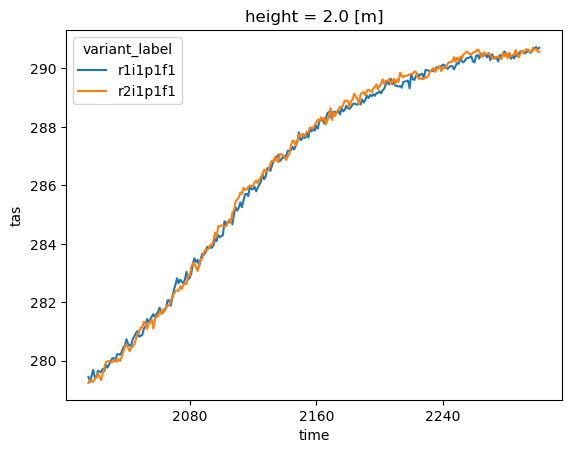

In [5]:
ds["tas"].mean(["lat", "lon"]).resample({"time": "Y"}).mean().plot.line(x="time")

Let's plot the accumulated precipitation over two periods of 20 years, the first period starting in 2015 and the second period starting in 2080.

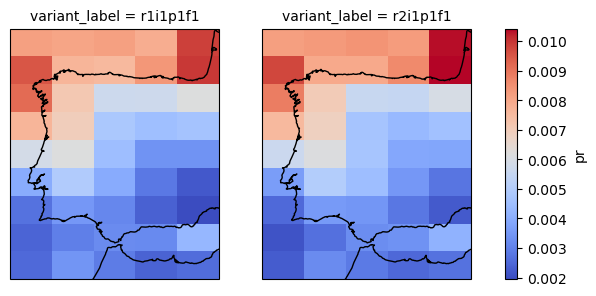

In [6]:
plot = ds["pr"].sel(lat=slice(35,45),lon=slice(350,360),time=slice("20150101", "20351231")).sum("time").plot(
        x="lon", y="lat", col="variant_label",
        add_colorbar=True,
        cmap="coolwarm",
        subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
        transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()

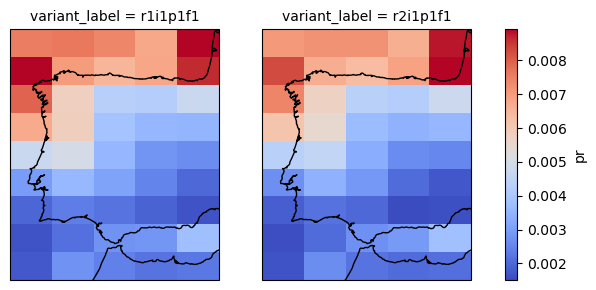

In [7]:
plot = ds["pr"].sel(lat=slice(35,45),lon=slice(350,360),time=slice("20800101", "21001231")).sum("time").plot(
        x="lon", y="lat", col="variant_label",
        add_colorbar=True,
        cmap="coolwarm",
        subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
        transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()

In [8]:
ds.close()

In [6]:
#tas_r1_2015_2100 = h5py.File("tas_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc", "r")
pr_r1_2015_2100 = h5py.File("pr_Amon_ACCESS-ESM1-5_ssp585_r1i1p1f1_gn_201501-210012.nc", "r")
print(dict(pr_r1_2015_2100["pr"].attrs))

{'standard_name': np.bytes_(b'precipitation_flux'), 'long_name': np.bytes_(b'Precipitation'), 'comment': np.bytes_(b'includes both liquid and solid phases'), 'units': np.bytes_(b'kg m-2 s-1'), 'cell_methods': np.bytes_(b'area: time: mean'), 'cell_measures': np.bytes_(b'area: areacella'), 'history': np.bytes_(b'2019-11-15T02:52:25Z altered by CMOR: replaced missing value flag (-1.07374e+09) with standard missing value (1e+20).'), 'missing_value': array([1.e+20], dtype=float32), '_FillValue': array([1.e+20], dtype=float32), 'DIMENSION_LIST': array([array([<HDF5 object reference>], dtype=object),
       array([<HDF5 object reference>], dtype=object),
       array([<HDF5 object reference>], dtype=object)], dtype=object)}
